In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import time
import os
import sys
import pickle
import sys
import copy
import math
import traceback

from data_preprocess import data_1D_to_2D
from channel_maps import channel_label_map, channel_loc_map
from MvmtOnsetDetect import *

In [17]:
os.getcwd()

'/home/sweet/2-coursework/725bmes/eeg_deeplearning/data_extraction/src'

# Load data

In [3]:
# db_dir = "C:/Users/Liangyu/Desktop/BME725/Final Project/eeg-deeplearning/neural_network/src"
db_dir = "/home/sweet/2-coursework/725bmes/eeg_deeplearning/data_extraction/src"
ME_db_fname = "prelim_ME_db_128.pickle"
ME_Kin_db_fname = "noneeg_ME_db_128.pickle"
rej_ME_db_fname = "reject_ME_db_128.pickle"
fs = 128
ME_db = {}
ME_kin_db = {}
rej_ME_db = {}

t1 = time.time()
with open(db_dir + "/" + rej_ME_db_fname, "rb") as f:
    rej_ME_db = pickle.load(f)
with open(db_dir + "/" + ME_db_fname, "rb") as f:
    ME_db = pickle.load(f)
with open(db_dir + "/" + ME_Kin_db_fname, "rb") as f:
    ME_kin_db = pickle.load(f)
print("Loaded ME database in %f s" % (time.time()-t1))

Loaded ME database in 3.562956 s


In [4]:
# baseline subtraction and infs/NaNs rejection
t1 = time.time()
ME_db_norm = copy.deepcopy(ME_db)
for i in range(1,8):
    for j in range(0,900):
        try:
            signal.detrend(ME_db_norm[i][j], axis=0, overwrite_data=True)
        except ValueError as e:    # add trials with infs/NaNs to rejected db
            rej_ME_db[i][j] = 1
            
print("Baseline subtraction and infs/NaNs rejection finished in %f s" % (time.time()-t1))

Baseline subtraction and infs/NaNs rejection finished in 4.729641 s


# Perform Movement Onset Detection

In [5]:
# map event type to event label
# class 1: 0x600 = 1536 (elbow flexion)
# class 2: 0x601 = 1537 (elbow extension)
# class 3: 0x602 = 1538 (supination)
# class 4: 0x603 = 1539 (pronation)
# class 5: 0x604 = 1540 (hand close)
# class 6: 0x605 = 1541 (hand open)
# class 7: 0x606 = 1542 (rest)

In [6]:
onsetAll = np.zeros((8,900))
chElbow = np.array([87, 88, 89]) - 65    # adjust for offset as indexed in ME_kin_db
chForeArm = np.array([94]) - 65
chHand = np.arange(65, 80) - 65
plot = False
t1 = time.time()

detectOnset(ME_kin_db, onsetAll, 1, chElbow, baselineEnd=16, threshV=1, threshdV=0.01, filt=17, plot=plot)
detectOnset(ME_kin_db, onsetAll, 2, chElbow, baselineEnd=16, threshV=1, threshdV=0.01, filt=17, plot=plot)
detectOnset(ME_kin_db, onsetAll, 3, chForeArm, baselineEnd=16, threshV=1, threshdV=0.01, filt=17, plot=plot)
detectOnset(ME_kin_db, onsetAll, 4, chForeArm, baselineEnd=16, threshV=1, threshdV=0.01, filt=17, plot=plot)
detectOnsetPCA(ME_kin_db, onsetAll, 5, chHand, baselineEnd=16, threshV=1, threshdV=0.01, filt=17, plot=plot)
detectOnsetPCA(ME_kin_db, onsetAll, 6, chHand, baselineEnd=16, threshV=1, threshdV=0.01, filt=17, plot=plot)

onsetAll[7,:] = np.mean(onsetAll[1:7,:])
onsetAll = onsetAll.astype(int)

print("Found movement onset in %f s" % (time.time()-t1))

Found movement onset in 7.753666 s


In [7]:
t1 = time.time()
ME_db_aligned = alignTrials(ME_db_norm, onsetAll, fs)
print("Created new structure in %f s" % (time.time()-t1))

t1 = time.time()
ME_kin_db_aligned = alignTrials(ME_kin_db, onsetAll, fs)
print("Created new structure in %f s" % (time.time()-t1))

[385, 7, 900, 257, 64]

Created new structure in 1.015355 s


[385, 7, 900, 257, 32]

Created new structure in 0.680924 s


(900, 257, 32)

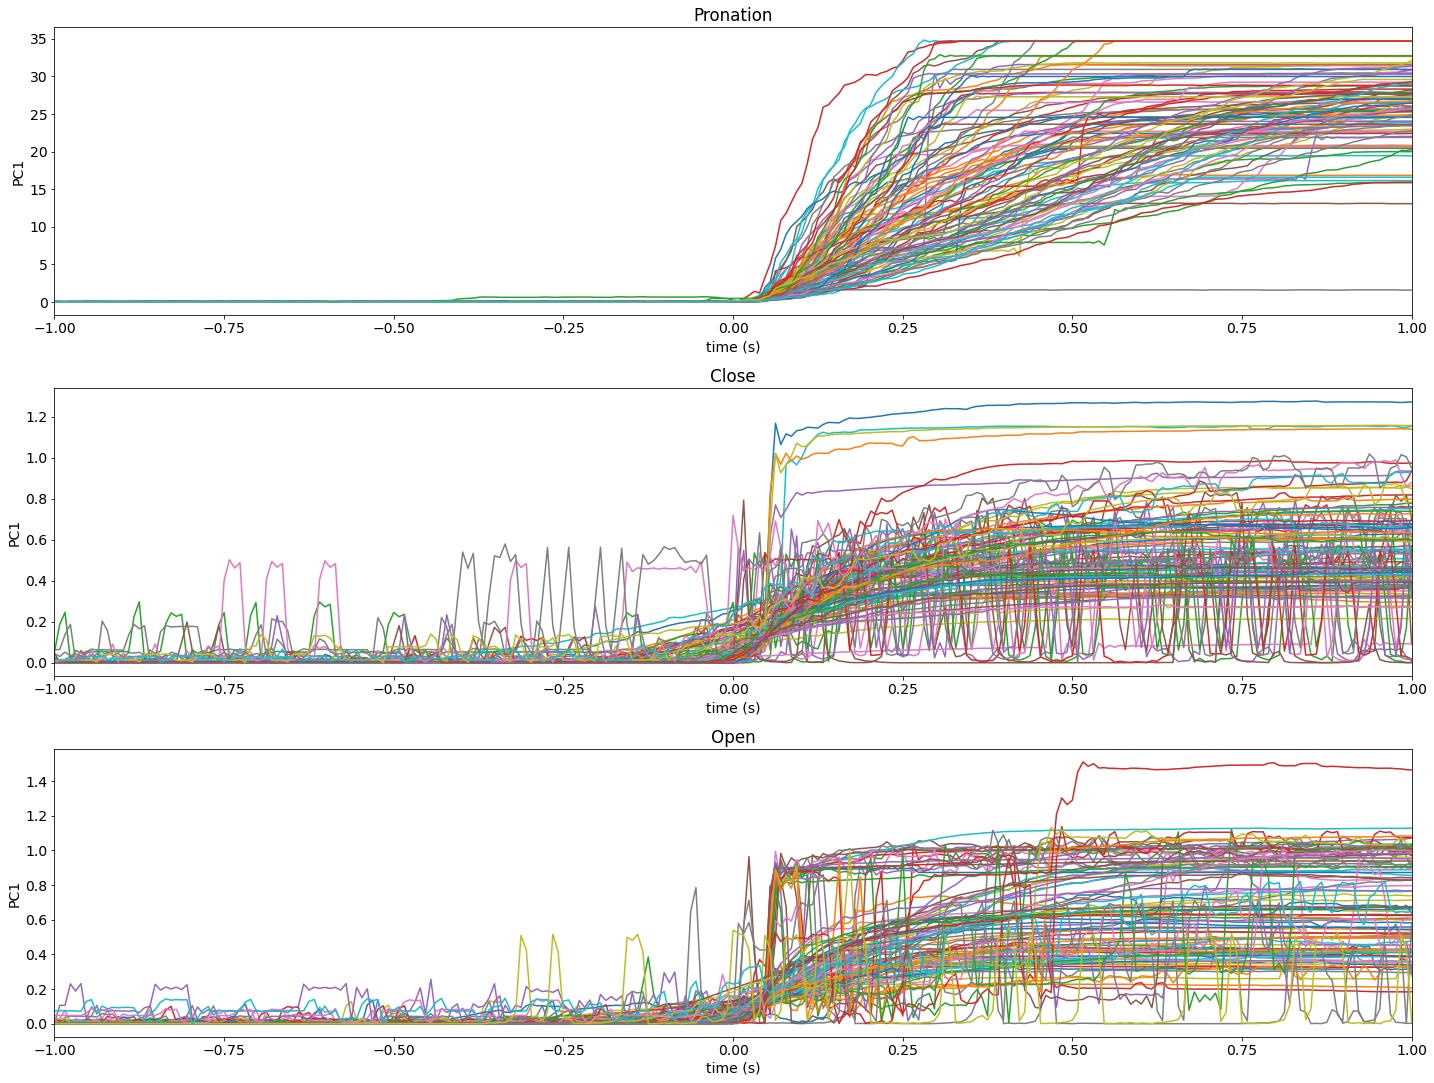

In [8]:
display(ME_kin_db_aligned[1].shape)
maxVals = np.zeros((6,900))

xRange = (np.arange(257)-(257-1)/2)/fs

plt.rcParams.update({'font.size': 14})

fig, (axs) = plt.subplots(3, 1, figsize = (20,15))
#plt.tight_layout()
for i in range(0,100):
    for j in range(1,3):
        tmp = abs(ME_kin_db_aligned[j][i][:,24])+abs(ME_kin_db_aligned[j][i][:,23])+abs(ME_kin_db_aligned[j][i][:,22])
        maxVals[j-1,i] = np.max(tmp)
        #if j==1:
        #    axs[0].plot(tmp)
        #if j==2:
        #    axs[1].plot(tmp)
        
    for j in range(3,5):
        tmp2 = abs(ME_kin_db_aligned[j][i][:,29]-np.mean(ME_kin_db_aligned[j][i][0:16,29]))
        maxVals[j-1,i] = np.max(tmp2)
        #if j==2:
        #    axs[2].plot(tmp2)
        if j==3:
            axs[0].plot(xRange,tmp2)
        
    for j in range(5,7):
        X = ME_kin_db_aligned[j][i][:,list(range(0, 14))]
        pca = PCA(n_components=np.shape(X)[1])
        PC = pca.fit_transform(X)
        tmp3 = abs(PC[:,0]-np.mean(PC[0:16,0]))
        maxVals[j-1,i] = np.max(tmp3)
        if j==5:
            axs[1].plot(xRange,tmp3)
        if j==6:
            axs[2].plot(xRange,tmp3)
            
claslabels = ['Pronation','Close','Open']            
for i in range(0,3):
    axs[i].set_xlim([xRange.min(),xRange.max()])
    axs[i].set_title(claslabels[i])
    axs[i].set_xlabel('time (s)')
    axs[i].set_ylabel('PC1')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# fig.savefig("MovementAlignOnset.pdf", bbox_inches='tight')

(900, 257, 32)

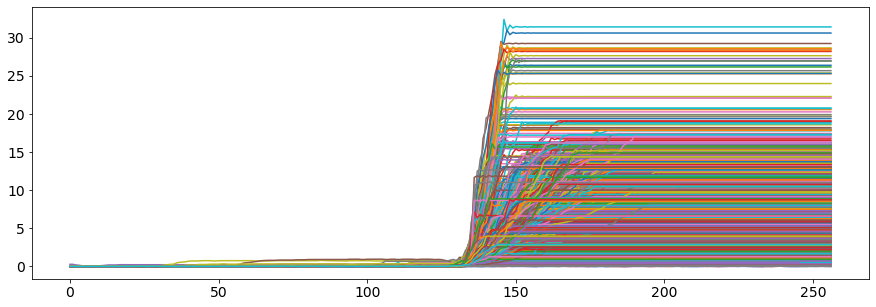

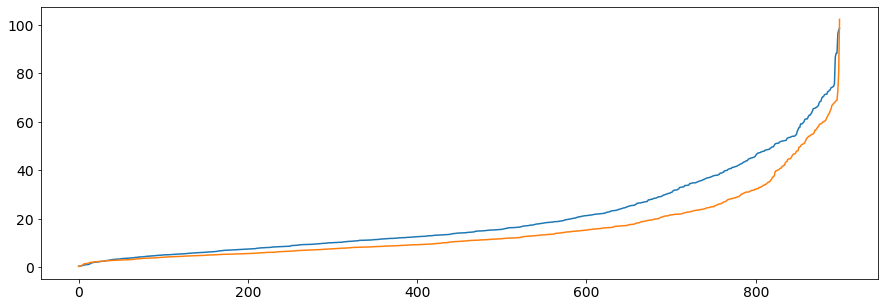

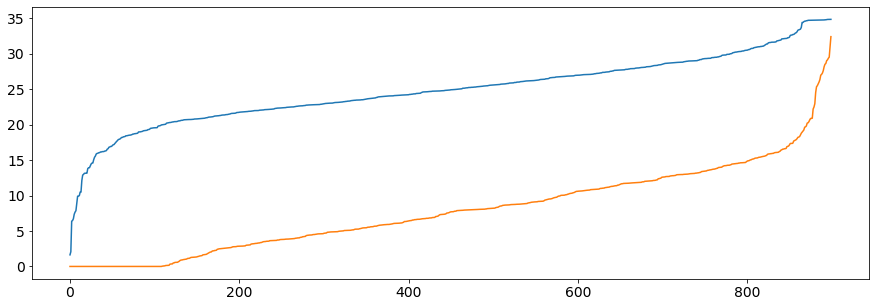

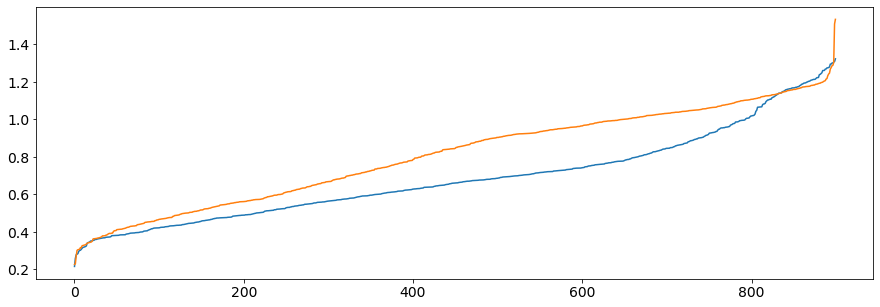

In [10]:
display(ME_kin_db_aligned[1].shape)
maxVals = np.zeros((6,900))
plt.figure(figsize = (15,5))
for i in range(0,900):
    for j in range(1,3):
        tmp = abs(ME_kin_db_aligned[j][i][:,24])+abs(ME_kin_db_aligned[j][i][:,23])+abs(ME_kin_db_aligned[j][i][:,22])
        maxVals[j-1,i] = np.max(tmp)
    for j in range(3,5):
        tmp2 = abs(ME_kin_db_aligned[j][i][:,29]-np.mean(ME_kin_db_aligned[j][i][0:16,29]))
        maxVals[j-1,i] = np.max(tmp2)
    for j in range(5,7):
        X = ME_kin_db_aligned[j][i][:,list(range(0, 14))]
        pca = PCA(n_components=np.shape(X)[1])
        PC = pca.fit_transform(X)
        tmp3 = abs(PC[:,0]-np.mean(PC[0:16,0]))
        maxVals[j-1,i] = np.max(tmp3)
    plt.plot(tmp2)
        
plt.figure(figsize = (15,5))
plt.plot(np.sort(maxVals[0,:]))
plt.plot(np.sort(maxVals[1,:]))

plt.figure(figsize = (15,5))
plt.plot(np.sort(maxVals[2,:]))
plt.plot(np.sort(maxVals[3,:]))

plt.figure(figsize = (15,5))
plt.plot(np.sort(maxVals[4,:]))
plt.plot(np.sort(maxVals[5,:]))

# Reject Abnormal Trials

In [11]:
t1 = time.time()

num_good_trials = np.zeros(8, dtype=int) # list storing the number of good trials per class after trial rejection
ME_db_aligned_no_art = {}
for clas in range(1,8):
    ME_db_aligned_no_art[clas] = None

for clas in range(1,8):
    reject_mask = np.array(rej_ME_db[clas])
    ME_db_aligned_no_art[clas] = np.delete(ME_db_aligned[clas], np.nonzero(reject_mask == 1), axis=0)
    num_good_trials[clas] = ME_db_aligned_no_art[clas].shape[0]
        
print("Removing artifacts %f s" % (time.time()-t1))

Removing artifacts 0.141971 s


In [13]:
min_num_good_trials = np.min(num_good_trials[1:])
display(min_num_good_trials)

for clas in range(1,8):
    ME_db_aligned_no_art[clas] = ME_db_aligned_no_art[clas][0:min_num_good_trials,:,:]

741

In [ ]:
# t1 = time.time()
# with open("ME_db_2D_mesh_no_art_128.pickle", "wb") as f:
#     i_str = pickle.dumps(ME_db_2D_mesh_no_art)
#     f_size = sys.getsizeof(i_str)/1048576
#     f.write(i_str)
# print("Finished writing %.2f MB of data to ME_db_2D_mesh_no_art_128.pickle in %f s" % (f_size, time.time()-t1))

In [14]:
ME_db_aligned_no_art[1].shape

(741, 257, 64)

# Convert from 1D to 2D

In [15]:
CLM = channel_loc_map()
# populate the mesh with the electrodes
mesh = [ [ "" for y in range(0,9) ] for x in range(0,9) ] 
for chan in range(0,np.shape(CLM)[0]):
    mesh[CLM[chan][0]][CLM[chan][1]] = channel_label_map[chan+1]

# print the 2D mesh of channels
for x in range(0,9): 
    print(mesh[x])

t1 = time.time()
ME_db_final_2D_mesh = data_1D_to_2D(ME_db_aligned_no_art, 9, 9, CLM)
print("Converting 1D to 2D mesh takes %f s" % (time.time()-t1))

['', '', '', '', 'F4', 'FFC6h', 'FC6', 'FTT8h', '']
['', '', '', 'F2', 'FFC4h', 'FC4', 'FCC6h', 'C6', 'TTP8h']
['', '', 'Fz', 'FFC2h', 'FC2', 'FCC4h', 'C4', 'CCP6h', 'CP6']
['', 'F1', 'FFC1h', 'FCz', 'FCC2h', 'C2', 'CCP4h', 'CP4', 'CPP6h']
['F3', 'FFC3h', 'FC1', 'FCC1h', 'Cz', 'CCP2h', 'CP2', 'CPP4h', 'P4']
['FFC5h', 'FC3', 'FCC3h', 'C1', 'CCP1h', 'CPz', 'CPP2h', 'P2', '']
['FC5', 'FCC5h', 'C3', 'CCP3h', 'CP1', 'CPP1h', 'Pz', 'PPO2h', '']
['FTT7h', 'C5', 'CCP5h', 'CP3', 'CPP3h', 'P1', 'PPO1h', '', '']
['', 'TTP7h', 'CP5', 'CPP5h', 'P3', '', '', '', '']
Converting 1D to 2D mesh takes 86.434797 s


In [16]:
t1 = time.time()
with open("mesh_ME_db_128.pickle", "wb") as f:
    i_str = pickle.dumps(ME_db_final_2D_mesh)
    f_size = sys.getsizeof(i_str)/1048576
    f.write(i_str)
print("Finished writing %.2f MB of data to mesh_ME_db_128.pickle in %f s" % (f_size, time.time()-t1))

Finished writing 823.81 MB of data to mesh_ME_db_128.pickle in 2.598286 s


# plot the raw mrcp

In [ ]:
plotMRCP(ME_kin_db_new, [29])
plotMRCP(ME_db_norm, [14, 27, 30, 31])
plotMRCP(ME_db_new, [14, 27, 30, 31])